<a href="https://colab.research.google.com/github/ilyesBoukraa/JPEG_img_compresison/blob/main/DCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Discrete Cosine Transform:
this algorithm basically find the signals (located in the image) that the human beings could not see and delete them.

# The formulas used
#  if  i = 0 
$$ T_{i,j} = \frac{1}{\sqrt{N}}$$ 
# Otherwise
$$T_{i,j} = \sqrt{ \frac{2}{N} } \cos{ \frac{ (2j+1)i\pi }{2N} } $$

In [ ]:
class Compression(object):
    def __init__(self, image):
        self.PI = np.pi
        self.img = image
        self.img_height , self.img_width = self.img.shape[:2]
    
    
    # Personal Note: this JPEG compression
    # works only with grayscale images
    # the colored images dct have another way to do
    # and it is not included in the course PDF
    # if you did not use it
    # it is okay you will get your 20/20
    # but for the sake of perfection do it
    # also remember to delete 
    # this comment before uploading it to github
    
    # So: for me in the future
    # if !grayscale ----> make it grayscale.
    
    def gray_scale(self):
        rgb_weights = np.array([0.3, 0.59,0.11])
        gray_img = np.dot(self.image[:,:,:3], rgb_weights)
        return gray_img

    # Not The Same formulas as the professor PDF
    # but much faster 2 loops instead of 4
    # the same result  
    # won't use it a lot
    # but it is better
    # because in the decompression i need only to transpose 
    
    def dct_sub_image(self, img, isDecompressed=False):
        sub_img = np.copy(img)
           
        blocksize = 8
        # N: Just So things doesn't get confusing
        N = blocksize

        T_ij = []
        for i in range(blocksize):
            row = []
            for j in range(blocksize):
                if(i==0):
                    result = 1/np.sqrt(N)
                    row.append( round(result,2) )
                else:
                    result = np.sqrt(2/N) * np.cos( ( (2*j+1)*i* self.PI ) / (2*N) ) 
                    row.append(round(result,2))
            T_ij.append(row)
        
        # I have to change it to numpy arrays
        # perhaps, i needed the numpy 
        # slicing stuff down the road
        
        T_ij = np.array(T_ij)
        dct_matrix = T_ij
       
        if( isDecompressed ):
            #The DCT matrix is Orthonormal so its inverse is its transpose.
            # Could change it just in the matrix product formulas, but to be more understanable..
            invers_dct_matrix = dct_matrix.T
            dct_sub_img = invers_dct_matrix @ sub_img @ invers_dct_matrix.T
            
            dct_sub_img = dct_sub_img + 128
            dct_sub_img = np.round(dct_sub_img)
        else:  
            sub_img = sub_img - 128.0
            dct_sub_img = dct_matrix @ sub_img @ dct_matrix.T
            dct_sub_img = dct_sub_img 
        
        #return dct_matrix
        return dct_sub_img
        
    def quantization(self, result_img, isDecompress=False):        
        sub_img = np.copy(result_img)    
        # From The Course PDF
        # With a Quality Level of 50
        # Being lazy and using AI 
        # to extract the text(quant matrix) from the image..
        
        quantization_Matrix = np.array([   [16, 11, 10, 16, 24, 40, 51, 61], 
                                           [12, 12, 14, 19, 26, 58, 60, 55], 
                                           [14, 13, 16, 24, 40, 57, 69, 56],
                                           [14, 17, 22, 29, 51, 87, 80, 62],
                                           [18, 22, 37, 56, 68, 109, 103, 77],
                                           [24, 35, 55, 64, 81, 104, 113, 92],
                                           [49, 64, 78, 87, 103, 121, 120, 101],
                                           [72, 92, 95, 98, 112, 100, 103, 99] ] , dtype = float)

        if(isDecompress):
            quantized_img = sub_img * quantization_Matrix
        else:
            quantized_img = sub_img / quantization_Matrix 

        return quantized_img

    
    def zigzag_scan(self, sub_img):
        A = np.copy(sub_img)
        h , w = A.shape[:2]

        my_list = []
        # First Half Of The Matrix
        for k in range(h):
            if( k%2 == 0 ):
                i = k
                j = 0
                while(i>=0 and i<= h-1 ):
                    #print("first half bottom-up ",i,j)
                    my_list.append(A[i][j])
                    i=i-1
                    j=j+1

            else:
                i = 0
                j = k
                while( j>=0 and j<=w-1 ):
                    #print("first half up-down ",i,j)
                    my_list.append(A[i][j])
                    i=i+1
                    j=j-1


        # K stands for number of diagonals in the matrix
        # which is : width  + height - 1 
        # the same as the first K 
        # but to not get you confused I explained it here
        
        # Second Half Of The Matrix
        
        # counter used for sliding
        # used when we are in the boundaries
        
        counter = 0

        for k in range(h,w+h-1):
            if( k%2 == 0 ):
                i = h-1
                j = 1+counter
                while(i<=h-1 and j<=w-1):
                    my_list.append(A[i][j])
                    i=i-1
                    j=j+1

                counter = counter +1

            else:
                i = 1+counter
                j = w-1
                while( j<=w-1 and i<=h-1 ):
                    my_list.append(A[i][j])
                    i=i+1
                    j=j-1

                counter = counter +1



        return np.array(my_list)

        # why another function?
        # the first used to convert a matrix into a vector
        # this one do the opposite: vect --> matrix
        
    def zigzag_scan_decompress(self,sub_vector):
        A = np.copy(sub_vector)
        h , w = 8,8
        n = len(A)
                
        my_matrix = np.zeros(shape = (8,8) , dtype=float)
        counter_v = 0
        
        # First Half Of The Matrix
        for k in range(h):
            if( k%2 == 0 ):
                i = k
                j = 0
                while(i>=0 and i<= h-1 ):
                    #print("first half bottom-up ",i,j)
                    my_matrix[i][j] = A[counter_v]
                    i=i-1
                    j=j+1
                    counter_v = counter_v + 1 
            else:
                i = 0
                j = k
                while( j>=0 and j<=w-1 ):
                    #print("first half up-down ",i,j)
                    my_matrix[i][j] = A[counter_v]
                    i=i+1
                    j=j-1
                    counter_v = counter_v + 1
        
        
        # K stands for number of diagonals in the matrix
        # which is : width  + height - 1
        
        # the same as the first K 
        # but to not get you confused I explained it here          
        
        # Second Half Of The Matrix
        # counter used for sliding
        # used when we are in the boundaries
        counter = 0
        
        for k in range(h,w+h-1):
            if( k%2 == 0 ):
                i = h-1
                j = 1+counter
                while(i<=h-1 and j<=w-1):
                    my_matrix[i][j] = A[counter_v]
                    i=i-1
                    j=j+1
                    counter_v = counter_v +1
            
                counter = counter +1
            
            else:
                i = 1+counter
                j = w-1
                while( j<=w-1 and i<=h-1 ):
                    my_matrix[i][j] = A[counter_v]
                    i=i+1
                    j=j-1
                    counter_v = counter_v +1
        
                counter = counter +1
        
        
         
        return my_matrix

    
    # Note Proud of that
    # rememmber you must figure out a better solution
    def run_lenght_encoding(self,vector):
        # np.copy why i am using it here? 
        # never ask...
        A = np.copy(vector)
        length = len(A)

        counter = 0
        char = A[0]
        compressed_list = []

        for i in range(0,length):
            if(char == A[i]):
                counter = counter + 1
            else:
                compressed_list.append(char)
                compressed_list.append(counter)
                char = A[i]
                counter = 1
            
            if(i == length-1):
                compressed_list.append(char)
                compressed_list.append(counter)


        return compressed_list

    def run_length_decoding(self,vector):
        
        length = len(vector)
        decompressed = []
        for i in range(0,length,2):
            if( i != length-1  ):
                A = vector[i]
                for j in range(int(vector[i+1])):
                    decompressed.append(A)
            
        return np.array(decompressed)
    
    
###########################################################################################################
    
    def img_compression(self):
        image = np.copy(self.img) 
        height, width = image.shape[:2]
        
        blocksize = 8
        vectorized_img = []
        for i in range(0, height - blocksize + 1, blocksize):
            for j in range(0, width - blocksize + 1, blocksize):
                sub_img = image[i:i+blocksize , j:j+blocksize]  
                dct = self.dct_sub_image(sub_img)
                quantized_dct = self.quantization(dct)
                quantized_dct = np.round(quantized_dct)
                vector = self.zigzag_scan(quantized_dct)
                compressed_vector = self.run_lenght_encoding(vector)
                vectorized_img.append( compressed_vector )
                
        return vectorized_img    
    
    
    # I did not TESTED it yet!
    # Note: I tested every single piece of it
    # why it is not working?
    # next 3ala Mbc Action
    
    # yeah because of 128.0 in the dct function
    # this way the variable will know that it is a float. 
    
    def img_decompression(self):
        
        vectors = self.img_compression()
        decompressed_img = np.zeros((self.img_height, self.img_width ))
        blocksize = 8
        i = 0
        j = 0
        z = 0
        blocks_nbr_row = self.img_width // blocksize
        
        factor = np.array( range(1, blocks_nbr_row+1) )
        
        for k in range(len(vectors)):
            
            sub_vect = self.run_length_decoding(vectors[k])
            matrix = self.zigzag_scan_decompress(sub_vect)
            
            inquantized_matrix = self.quantization(matrix, isDecompress=True) 
            new_sub_image = self.dct_sub_image(inquantized_matrix, isDecompressed=True)
            
            if( k < blocks_nbr_row * factor[z]  ):
                decompressed_img[i:i+blocksize , j:j+blocksize] = new_sub_image
                j = j + blocksize
                
            else:
                i = i + blocksize
                j = 0
                
                decompressed_img[i:i+blocksize , j:j+blocksize] = new_sub_image
                j = j + blocksize
    
                z = z + 1
                
        return decompressed_img 
    
###########################################################################################################

# Loading The Data

In [ ]:
#PATH = 'images\\lena_gray.bmp'
PATH = 'images\\barbara_gray.bmp'
bmp_img = plt.imread(PATH)

# JPEG Compression 

In [ ]:
%%time
JPEG = Compression(bmp_img)
decompressed_img = JPEG.img_decompression()

Wall time: 4.98 s


# Testing The Results

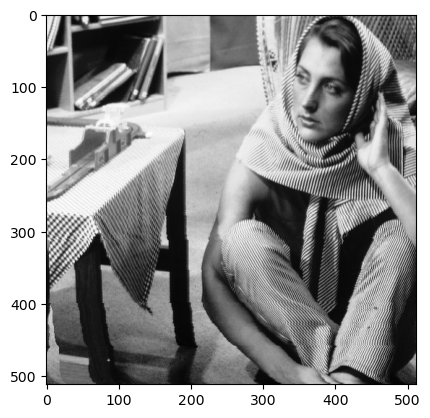

In [ ]:
plt.imshow(bmp_img , cmap = 'gray')
plt.show()

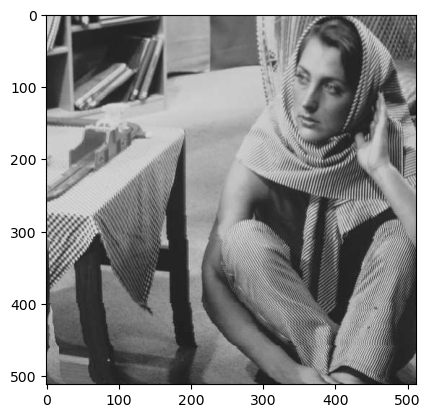

In [ ]:
plt.imshow(decompressed_img , cmap = 'gray')
plt.show()